***
#### Importing Libraries
****

In [1]:
import os
import librosa
import numpy as np
import pandas as pd

***
#### Emotion mapping from filename
***

In [3]:
emotion_map = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}


***
#### function that extract features like mfccs, chroma, mel, zcr, rmse
***

In [27]:
def extract_features(y,sr):
    mfccs=np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=13).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y,sr=sr).T,axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T,axis=0)
    rmse = np.mean(librosa.feature.rms(y=y).T, axis=0)
    return np.hstack([mfccs,chroma,mel[:13],zcr,rmse])

***
#### Function to get all wav files from subfolders
***

In [12]:
def get_all_audio_files(root_folder,extension='.wav'):
    audio_files = []
    for dirpath,_,filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith(extension):
                full_path = os.path.join(dirpath,file)
                audio_files.append(full_path)
    return audio_files

***
#### Dataset loader
****

In [29]:
def load_ravdess_dataset(root_path,max_files=None):
    data = []
    count = 0
    audio_files = get_all_audio_files(root_path)
    for file_path in audio_files:
        if max_files and count >= max_files:
            break

        # Extracting emotion label from filename
        file_name = os.path.basename(file_path)
        emotion_id = file_name.split("-")[2]
        emotion = emotion_map.get(emotion_id)
        if emotion is None:
            continue

        try:
            y,sr = librosa.load(file_path,sr = None)
            features = extract_features(y,sr)
            data.append([features,emotion])
            count +=1
        except Exception as e:
            print(f'Error While Processing {file_name}:{e}')
    return pd.DataFrame(data,columns = ['features','emotion'])

In [15]:
all_audio_files = get_all_audio_files(r'DataSets/Audio_Speech_Actors_01-24/')
print(len(all_audio_files))
all_audio_files[:5]

1440


['DataSets/Audio_Speech_Actors_01-24/Actor_01\\03-01-01-01-01-01-01.wav',
 'DataSets/Audio_Speech_Actors_01-24/Actor_01\\03-01-01-01-01-02-01.wav',
 'DataSets/Audio_Speech_Actors_01-24/Actor_01\\03-01-01-01-02-01-01.wav',
 'DataSets/Audio_Speech_Actors_01-24/Actor_01\\03-01-01-01-02-02-01.wav',
 'DataSets/Audio_Speech_Actors_01-24/Actor_01\\03-01-02-01-01-01-01.wav']

***
#### Coverting Features Columns to more 41 Columns
***

In [42]:
mfccs = [f'mfcc_{i+1}' for i in range(13)]
chroma = [f'chroma_{i+1}' for i in range(12)]
mel = [f'mel_{i+1}' for i in range(13)]
others = ['zcr', 'rmse']

feature_names = mfccs + chroma + mel + others  # total = 40


In [43]:
# Convert the list column into a new DataFrame
features_df = pd.DataFrame(df['features'].tolist(), columns=feature_names)

# Combine with original DataFrame (excluding original 'features' column)
df_final = pd.concat([df.drop('features', axis=1), features_df], axis=1)


In [44]:
print(df_final.shape)  # Should be (num_samples, 1 + 40)
print(df_final.columns)

(1440, 41)
Index(['emotion', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6',
       'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5',
       'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10',
       'chroma_11', 'chroma_12', 'mel_1', 'mel_2', 'mel_3', 'mel_4', 'mel_5',
       'mel_6', 'mel_7', 'mel_8', 'mel_9', 'mel_10', 'mel_11', 'mel_12',
       'mel_13', 'zcr', 'rmse'],
      dtype='object')


In [69]:
x = df_final.drop(['emotion'],axis=1)
y = df_final.emotion

***
#### Doing Some EDA
***

In [71]:
df_final.describe()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mel_6,mel_7,mel_8,mel_9,mel_10,mel_11,mel_12,mel_13,zcr,rmse
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,-617.135425,66.092421,-4.855443,10.203428,-0.221090,8.248786,-8.382126,0.882888,-7.187926,-5.599998,...,0.114592,0.181932,0.266258,0.318284,0.279426,0.366671,0.529755,0.563293,0.069216,0.010056
std,102.579621,14.824665,11.792966,8.137515,6.869429,7.182301,6.067137,5.215737,4.970867,4.349589,...,0.247349,0.417661,0.645087,0.877096,0.817976,1.188573,2.337069,2.778393,0.018194,0.012293
min,-873.242310,18.962200,-51.957912,-17.508692,-22.980276,-11.918347,-29.964558,-16.975170,-21.486061,-21.439531,...,0.000018,0.000034,0.000052,0.000070,0.000023,0.000043,0.000294,0.000152,0.027717,0.000328
25%,-693.664764,55.786286,-12.181197,4.912715,-4.880035,2.871039,-12.373206,-2.674862,-10.828943,-8.717091,...,0.008254,0.013359,0.017727,0.011300,0.007714,0.010691,0.015726,0.018301,0.057009,0.002892
50%,-622.848907,66.310318,-4.090637,10.303168,-0.376970,8.562731,-8.939194,0.726703,-7.731442,-5.620663,...,0.035258,0.045454,0.054676,0.049463,0.034471,0.045950,0.061627,0.068277,0.066405,0.005693
75%,-551.604279,76.615622,3.577858,15.061989,4.965186,13.645656,-4.223574,4.265066,-3.371512,-2.330798,...,0.096160,0.152129,0.202432,0.177710,0.149464,0.197974,0.238499,0.265498,0.079508,0.011736
max,-333.377960,115.125786,22.603916,36.563427,21.130016,27.950075,10.092591,16.410280,6.087853,7.422122,...,3.276654,5.800738,7.592804,10.986993,12.428693,19.232307,48.831566,45.836243,0.168519,0.088503


In [73]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   emotion    1440 non-null   object 
 1   mfcc_1     1440 non-null   float64
 2   mfcc_2     1440 non-null   float64
 3   mfcc_3     1440 non-null   float64
 4   mfcc_4     1440 non-null   float64
 5   mfcc_5     1440 non-null   float64
 6   mfcc_6     1440 non-null   float64
 7   mfcc_7     1440 non-null   float64
 8   mfcc_8     1440 non-null   float64
 9   mfcc_9     1440 non-null   float64
 10  mfcc_10    1440 non-null   float64
 11  mfcc_11    1440 non-null   float64
 12  mfcc_12    1440 non-null   float64
 13  mfcc_13    1440 non-null   float64
 14  chroma_1   1440 non-null   float64
 15  chroma_2   1440 non-null   float64
 16  chroma_3   1440 non-null   float64
 17  chroma_4   1440 non-null   float64
 18  chroma_5   1440 non-null   float64
 19  chroma_6   1440 non-null   float64
 20  chroma_7

In [58]:
import seaborn as sns
from matplotlib import pyplot as plt

<Axes: >

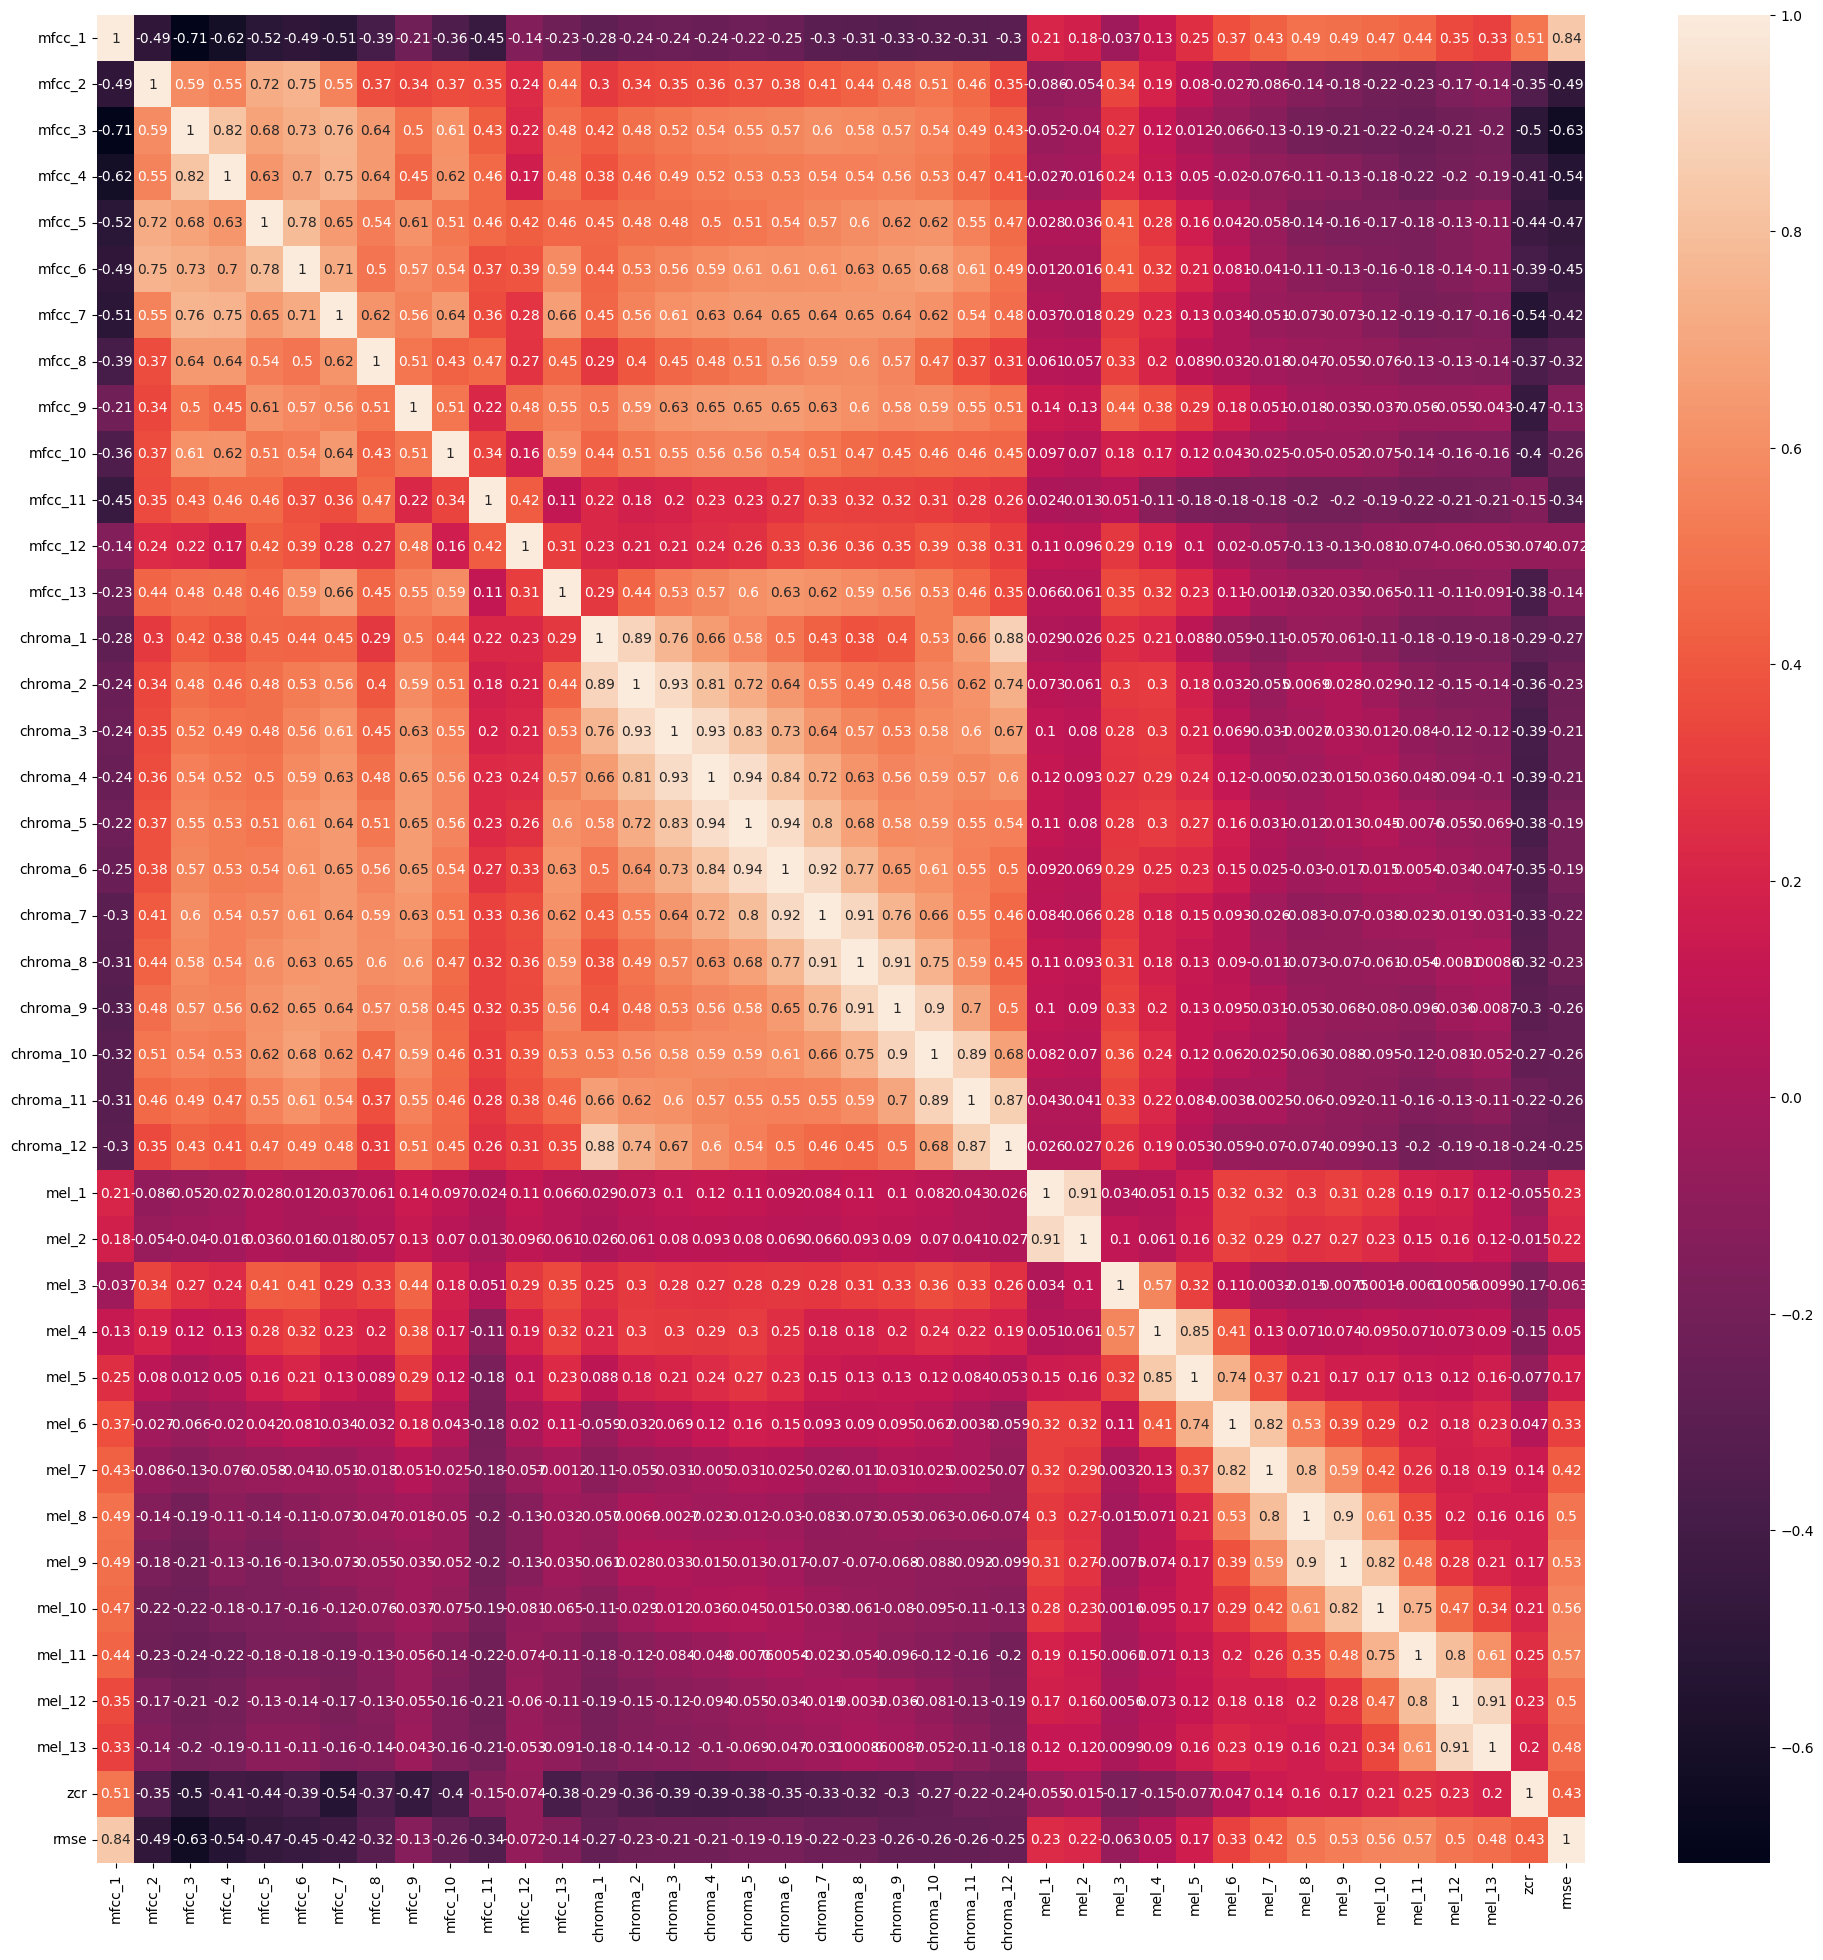

In [63]:
plt.figure(figsize=(24,24))
sns.heatmap(x.corr(),annot=True)


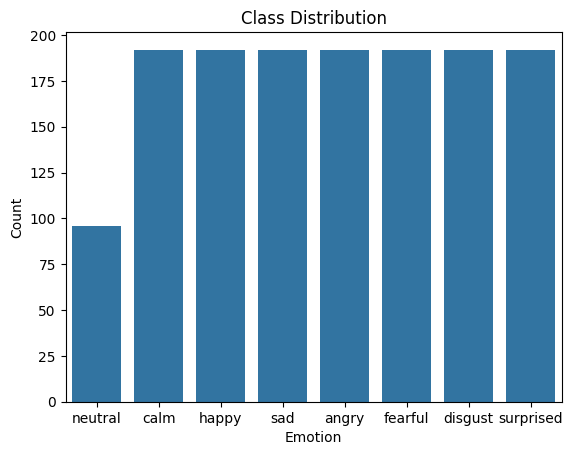

In [64]:
sns.countplot(data=df_final, x='emotion')
plt.title("Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

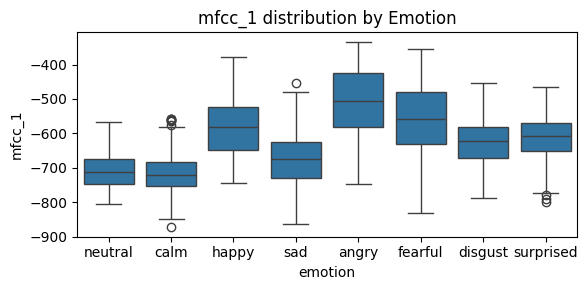

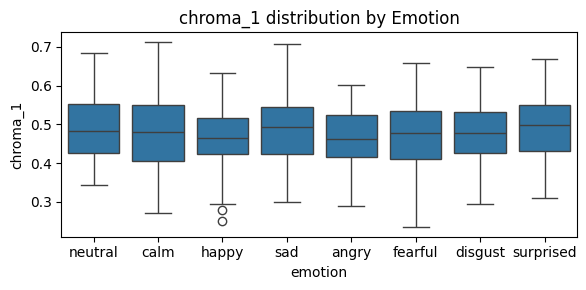

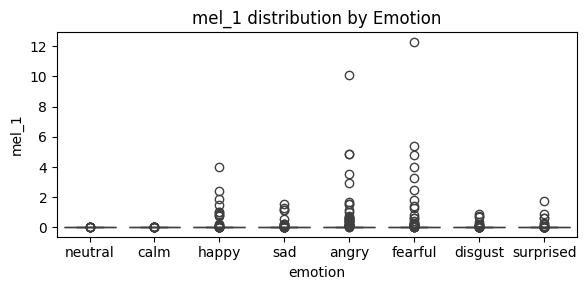

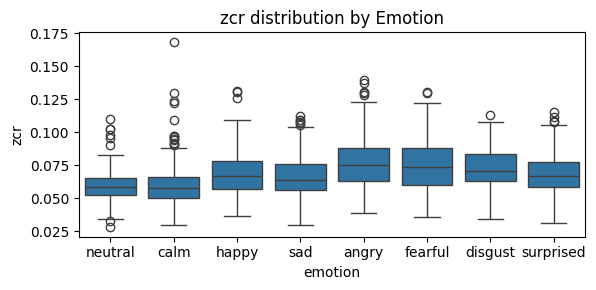

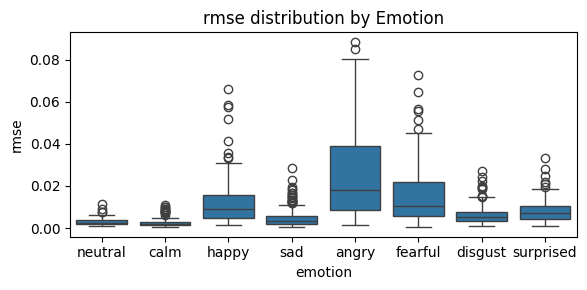

In [65]:
features_to_plot = ['mfcc_1', 'chroma_1', 'mel_1', 'zcr', 'rmse']

for feature in features_to_plot:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='emotion', y=feature, data=df_final)
    plt.title(f'{feature} distribution by Emotion')
    plt.tight_layout()
    plt.show()

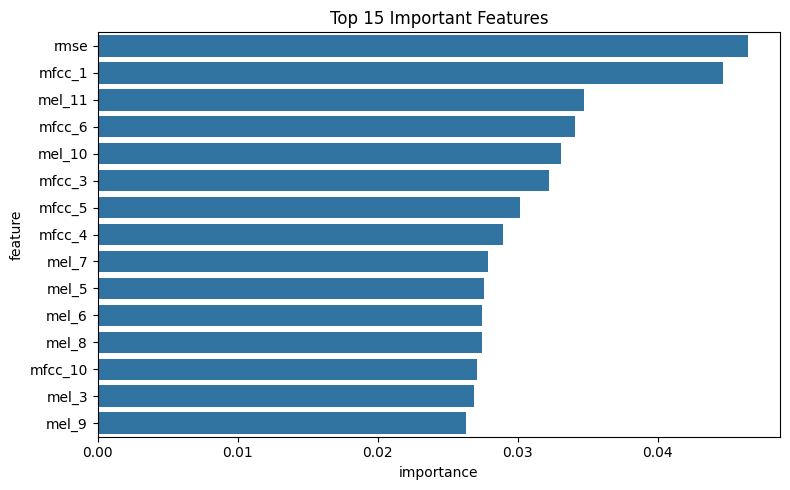

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(df_final['emotion'])

rf = RandomForestClassifier()
rf.fit(x, y_encoded)

importances = rf.feature_importances_
feature_names = x.columns

# Plot
feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_df = feat_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=feat_df.head(15))
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()


<div style="background-color: #a96fff;">

***
## Building a Classification model
***
</div>

<div style="background-color: #ff9f6f;">
    
***
#### Importing Sklearn Libraries
***
</div>

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

<div style="background-color: #ff9f6f;">
    
***
#### Creating x and y Variable
***
</div>

In [79]:
x = df_final.drop(['emotion'],axis=1)
y = df_final.emotion

<div style="background-color: #ff9f6f;">
    
***
#### Doing Label Encoding On x variable
***
</div>

In [80]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

label_map = dict(zip(le.classes_,le.transform(le.classes_)))
print(label_map)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


<div style="background-color: #ff9f6f;">
    
***
#### Spliting data in Train and Test
***
</div>

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

<div style="background-color: #ff9f6f;">
    
***
#### Feature Scalling
***
</div>

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

<div style="background-color: #fffa9d;">
    
***
#### Function that Print Classification report and Confusion Matrix
***
</div>

In [90]:
def evalute_model(y_true,y_pred,model_name):
    print(f'Evaluation Report for {model_name}')
    print(confusion_matrix(y_true,y_pred))
    print(classification_report(y_true,y_pred,target_names=le.classes_))

    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt='d',
               xticklabels=le.classes_,yticklabels=le.classes_,cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

<div style="background-color: #9dc0ff;">
    
***
#### Random Foret Classifier
***
</div>

In [104]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

Evaluation Report for Random Forest
[[27  0  8  0  1  0  0  2]
 [ 0 31  3  2  0  2  0  0]
 [ 3  2 17  1  3  4  2  6]
 [ 4  0  6 22  4  0  1  2]
 [ 3  4  4 10 12  1  2  3]
 [ 0  5  5  0  0  5  2  2]
 [ 0  8  6  4  1  4 12  3]
 [ 1  3  3  3  3  2  0 24]]
              precision    recall  f1-score   support

       angry       0.71      0.71      0.71        38
        calm       0.58      0.82      0.68        38
     disgust       0.33      0.45      0.38        38
     fearful       0.52      0.56      0.54        39
       happy       0.50      0.31      0.38        39
     neutral       0.28      0.26      0.27        19
         sad       0.63      0.32      0.42        38
   surprised       0.57      0.62      0.59        39

    accuracy                           0.52       288
   macro avg       0.52      0.50      0.50       288
weighted avg       0.53      0.52      0.51       288



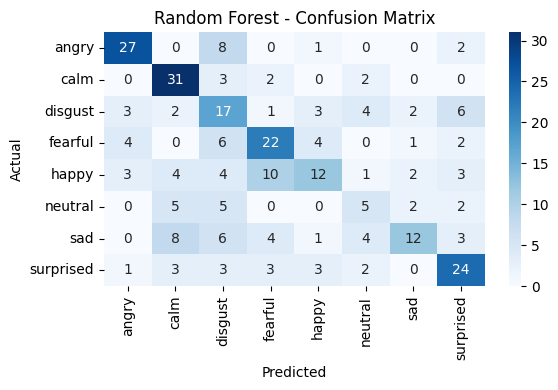

In [91]:
evalute_model(y_test,rf_preds,'Random Forest')

<div style="background-color: #9dc0ff;">
    
***
#### Support Vector Machine
***
</div>


In [105]:

svm_model = SVC(kernel='rbf',C=1,gamma='scale',random_state=42)
svm_model.fit(X_train_scaled,y_train)
svm_preds= svm_model.predict(X_test_scaled)

Evaluation Report for SVM (RBF)
[[25  3  4  1  2  0  0  3]
 [ 0 32  0  0  0  1  4  1]
 [ 3  7 18  1  2  0  1  6]
 [ 7  3  5 14  3  0  2  5]
 [ 2  2  7  9 14  0  1  4]
 [ 0  5  6  0  0  2  5  1]
 [ 0 12  5  2  5  1 10  3]
 [ 0  5  3  6  7  0  1 17]]
              precision    recall  f1-score   support

       angry       0.68      0.66      0.67        38
        calm       0.46      0.84      0.60        38
     disgust       0.38      0.47      0.42        38
     fearful       0.42      0.36      0.39        39
       happy       0.42      0.36      0.39        39
     neutral       0.50      0.11      0.17        19
         sad       0.42      0.26      0.32        38
   surprised       0.42      0.44      0.43        39

    accuracy                           0.46       288
   macro avg       0.46      0.44      0.42       288
weighted avg       0.46      0.46      0.44       288



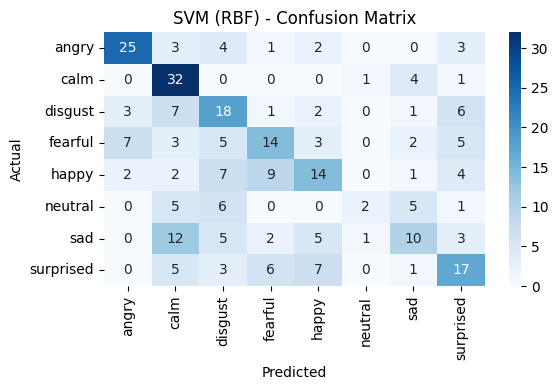

In [92]:
evalute_model(y_test,svm_preds,'SVM (RBF)')

<div style="background-color: #9dc0ff;">
    
***
#### Naive bayes Classifer
***
</div>


Evaluation Report for Naive Bayes
[[14  0 12  2  2  0  5  3]
 [ 0  0  2  0  0  0 36  0]
 [ 0  0 12  0  2  0 22  2]
 [ 8  0 11  5  6  0  6  3]
 [ 3  0  6  2  7  0 19  2]
 [ 0  1  3  0  0  0 15  0]
 [ 0  0  5  1  0  0 30  2]
 [ 1  0 17  3  2  0 16  0]]
              precision    recall  f1-score   support

       angry       0.54      0.37      0.44        38
        calm       0.00      0.00      0.00        38
     disgust       0.18      0.32      0.23        38
     fearful       0.38      0.13      0.19        39
       happy       0.37      0.18      0.24        39
     neutral       0.00      0.00      0.00        19
         sad       0.20      0.79      0.32        38
   surprised       0.00      0.00      0.00        39

    accuracy                           0.24       288
   macro avg       0.21      0.22      0.18       288
weighted avg       0.22      0.24      0.19       288



C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

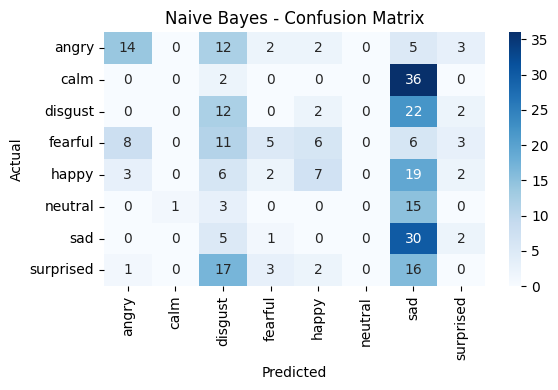

In [111]:
naive = GaussianNB()
naive.fit(X_train_scaled,y_train)
naive_preds = naive.predict(X_test_scaled)
evalute_model(y_test,naive_preds,'Naive Bayes')

<div style="background-color: #9dc0ff;">
    
***
#### Gradient Boosting
***
</div>

Evaluation Report for Gradient Boosting
[[24  5  3  2  0  0  1  3]
 [ 0 25  3  5  0  0  5  0]
 [ 5  9  9 12  0  0  1  2]
 [ 3  4  2 25  1  0  4  0]
 [ 0 12  1  9 10  0  2  5]
 [ 0 14  2  1  0  0  2  0]
 [ 0  9  2 11  0  1 11  4]
 [ 2  9  5  9  1  0  3 10]]
              precision    recall  f1-score   support

       angry       0.71      0.63      0.67        38
        calm       0.29      0.66      0.40        38
     disgust       0.33      0.24      0.28        38
     fearful       0.34      0.64      0.44        39
       happy       0.83      0.26      0.39        39
     neutral       0.00      0.00      0.00        19
         sad       0.38      0.29      0.33        38
   surprised       0.42      0.26      0.32        39

    accuracy                           0.40       288
   macro avg       0.41      0.37      0.35       288
weighted avg       0.44      0.40      0.38       288



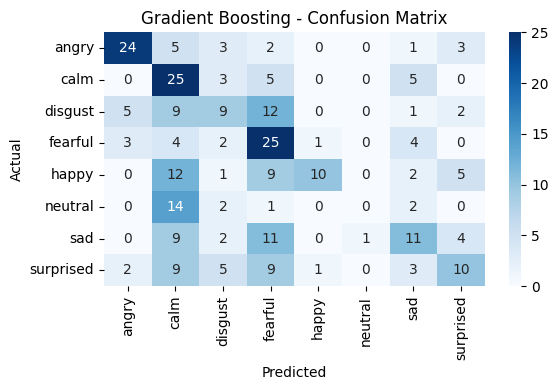

In [112]:
gb_model = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)
gb_model.fit(X_train_scaled,y_train)
gb_preds = gb_model.predict(X_test_scaled)
evalute_model(y_test,gb_preds,'Gradient Boosting')

<div style="background-color: #9dc0ff;">
    
***
#### KNeighborsClassifier
***
</div>

In [108]:
KNN = KNeighborsClassifier()
KNN.fit(X_train_scaled,y_train)
KNN_preds = KNN.predict(X_test_scaled)

Evaluation Report for KNeighborsClassifier
[[24  1  2  3  1  1  0  6]
 [ 0 30  1  1  0  4  1  1]
 [ 9  2 20  0  0  3  0  4]
 [ 5  2  5 14  7  1  3  2]
 [ 8  2  4  4 14  1  1  5]
 [ 0  5  1  1  0  9  2  1]
 [ 5  6  2  4  1  6 12  2]
 [ 3  2  4  5  3  3  1 18]]
              precision    recall  f1-score   support

       angry       0.44      0.63      0.52        38
        calm       0.60      0.79      0.68        38
     disgust       0.51      0.53      0.52        38
     fearful       0.44      0.36      0.39        39
       happy       0.54      0.36      0.43        39
     neutral       0.32      0.47      0.38        19
         sad       0.60      0.32      0.41        38
   surprised       0.46      0.46      0.46        39

    accuracy                           0.49       288
   macro avg       0.49      0.49      0.48       288
weighted avg       0.50      0.49      0.48       288



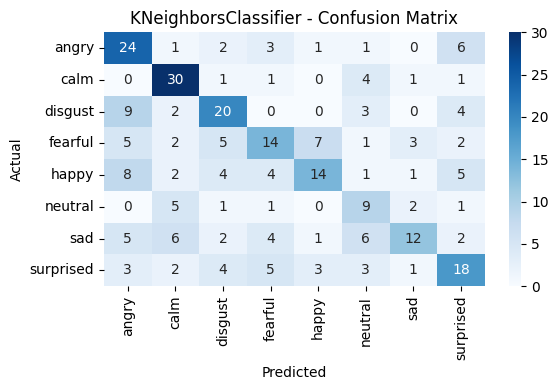

In [113]:
evalute_model(y_test,KNN_preds,'KNeighborsClassifier')

<div style="background-color: #b29dff;">
    
***
#### Grid Search CV on Random Forest
***
</div>

In [114]:
from sklearn.model_selection import GridSearchCV

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best RF Params: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF Accuracy (CV): 0.6033013363448145
Evaluation Report for Random Forest Tuned
[[29  1  4  0  1  0  1  2]
 [ 0 30  2  2  0  3  1  0]
 [ 3  5 17  1  2  2  2  6]
 [ 2  0  5 25  3  0  3  1]
 [ 3  3  4 10 16  0  1  2]
 [ 0  5  4  0  0  6  3  1]
 [ 0  8  3  4  1  1 20  1]
 [ 4  4  1  0  2  0  2 26]]
              precision    recall  f1-score   support

       angry       0.71      0.76      0.73        38
        calm       0.54      0.79      0.64        38
     disgust       0.42      0.45      0.44        38
     fearful       0.60      0.64      0.62        39
       happy       0.64      0.41      0.50        39
     neutral       0.50      0.32      0.39        19
         sad       0.61      0.53      0.56        38
   surprised       0.67      0.67      0.67        39

    accuracy             

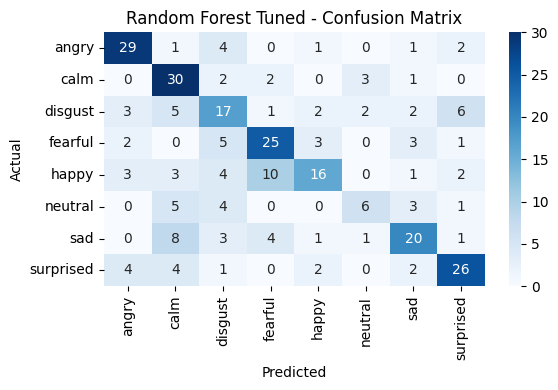

In [115]:
rf_params = {
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False]
}
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv = 5,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train,y_train)
print('Best RF Params:',rf_grid.best_params_)
print('Best RF Accuracy (CV):',rf_grid.best_score_)

rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(X_test)
evalute_model(y_test,rf_preds,'Random Forest Tuned')

<div style="background-color: #b29dff;">
    
***
#### Grid Search CV on SVC
***
</div>

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM Params {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Score 0.6032749858836814
Evaluation Report for Tuned Support Vector Classifier
[[29  2  3  1  2  0  1  0]
 [ 0 29  1  1  0  5  1  1]
 [ 3  2 24  0  1  4  1  3]
 [ 0  1  2 23  2  0  6  5]
 [ 1  0  5  7 22  1  0  3]
 [ 0  4  5  0  0  9  0  1]
 [ 2  6  4  5  4  4 11  2]
 [ 1  2  5  7  3  2  0 19]]
              precision    recall  f1-score   support

       angry       0.81      0.76      0.78        38
        calm       0.63      0.76      0.69        38
     disgust       0.49      0.63      0.55        38
     fearful       0.52      0.59      0.55        39
       happy       0.65      0.56      0.60        39
     neutral       0.36      0.47      0.41        19
         sad       0.55      0.29      0.38        38
   surprised       0.56      0.49      0.52        39

    accuracy                           0.58       288
   macro avg       0.57      0.

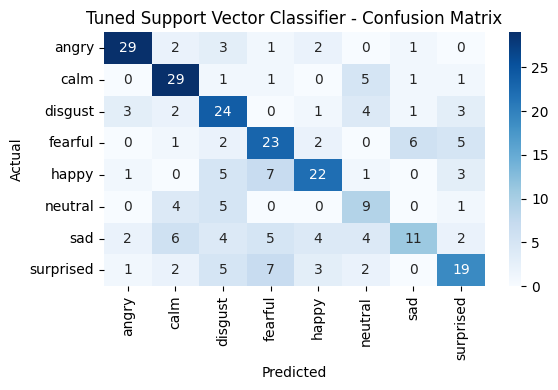

In [117]:
svm_params = {
    'C':[0.1,1,10,100],
    'gamma':['scale','auto',0.01,0.001],
    'kernel':['rbf']
}

svm_grid = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=svm_params,
    cv= 5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_scaled,y_train)

print('Best SVM Params',svm_grid.best_params_)
print('Best SVM Score',svm_grid.best_score_)

svm_best = svm_grid.best_estimator_
svm_preds = svm_best.predict(X_test_scaled)
evalute_model(y_test,svm_preds,'Tuned Support Vector Classifier')

<div style="background-color: #fffd9d;">
    
***
## Exporting SVM model, encoder and scaler
***
</div>

In [118]:
import joblib

In [121]:
joblib.dump(scaler,'scaler.pkl')
joblib.dump(le,'label_encoder.pkl')
joblib.dump(svm_best,'best_svm_model.pkl')

['best_svm_model.pkl']